In [1]:
%%capture
import site
import numpy as np
import matplotlib
path = '/home/cosinga/figrid/'

site.addsitedir(path)
from figrid.data_sort import DataSort
from figrid.data_container import DataContainer

In [2]:
matplotlib.__version__

'3.5.2'

In [106]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from figrid.data_container import DataContainer
import copy

class Figrid():
   
    def __init__(self, panels, panel_attr, row_values, col_values):
        self.row_values = row_values
        self.col_values = col_values
        self.panel_attr = panel_attr
        self.panels = panels
        self.panelsize = [3, 3]
        self.dim = panels.shape

        empty_types = {'both':{}, 'major':{}, 'minor':{}}
        empty_ticks = {}; axes_list = ['x', 'y', 'both']
        for a in axes_list:
            empty_ticks[a] = copy.deepcopy(empty_types)
        self.tick_args = self._emptyDicts(panels.shape, empty_ticks)

        self.axis_args = self._emptyDicts(panels.shape, {})

        self.leg_args = {}
        
        self.gspec_args = {}
        gspec_args = {
            'height_ratios' : np.ones(self.dim[0]),
            'width_ratios' : np.ones(self.dim[1]),
            'hspace' : 0.25,
            'wspace' : 0.25,
            'xborder' : np.array([0.33, 0]),
            'yborder' : np.array([0, 0.33])
        }
        self.gspecArgs(gspec_args)
        
        self.fig_args = {}
        self.calculateFigsize()

        empty_spines = {'bottom':{}, 'left':{}, 'right':{}, 'top':{}}
        self.spine_args = self._emptyDicts(panels.shape, empty_spines)


        self.axis_label_args = {'x':{}, 'y':{}, 'both':{}}
        self.row_label_args = ()
        self.col_label_args = ()
        self.row_labels = []
        self.col_labels = []
        self.plot_order = []
        self.legend_slc = None

        self.fig = None
        return

    def _emptyDicts(self, shape, dict_element):
        empty = np.empty(shape, dtype=object)
        for i in range(shape[0]):
            for j in range(shape[1]):
                empty[i, j] = copy.deepcopy(dict_element)
        return empty

    ########## MAKING FIGURES #####################################
    def _makeAxes(self):
        fig = self.fig
        
        ga = self.gspec_args
        nrows = self.dim[0]; ncols = self.dim[1]
        hrs = ga['height_ratios']
        wrs = ga['width_ratios']
        yb = ga['yborder']; xb = ga['xborder']
        hs = ga['hspace']; ws = ga['wspace']
        figsize = self.calculateFigsize()
        figwidth = figsize[0]; figheight = figsize[1]

        panel_width = self.panelsize[0]
        panel_height = self.panelsize[1]
        width_ratios = wrs * panel_width; height_ratios = hrs * panel_height
        xborder = xb * panel_width; yborder = yb * panel_height
        wspace = ws * panel_width; hspace = hs * panel_height
        
        
        axes = np.empty((nrows, ncols), dtype = object)
        for i in range(nrows):
            for j in range(ncols):
                # a label makes each axis unique - otherwise mpl will
                # return a previously made axis
                
                ax = fig.add_subplot(label = str((i, j)))
                
                height = height_ratios[i]
                width = width_ratios[j]
                
                total_hspace = np.sum(hspace[:i])
                total_heights = np.sum(height_ratios[:i+1])
                total_widths = np.sum(width_ratios[:j])
                total_wspace = np.sum(wspace[:j])
                
                bot = figheight - yborder[0] - total_hspace - total_heights
                left = xborder[0] + total_widths + total_wspace
                
                axdim = [left / figwidth, bot / figheight, 
                        width / figwidth, height / figheight]
                print(axdim)
                ax.set_position(axdim)
                axes[i, j] = ax
        
        self.axes = axes
        return
    
    def gspecArgs(self, gspec_kwargs = {}, **other_kwargs):
            
        gspec_kwargs.update(other_kwargs)
        self.gspec_args.update(gspec_kwargs)
        
        ga = self.gspec_args
        nrows, ncols = self.dim
        height_ratios = ga['height_ratios']
        width_ratios = ga['width_ratios']
        yborder = ga['yborder']; xborder = ga['xborder']
        hspace = ga['hspace']; wspace = ga['wspace']
        
        # default behavior for borders
        if isinstance(xborder, float) or isinstance(xborder, int):
            xborder = np.array([xborder, xborder])
        if isinstance(yborder, float) or isinstance(yborder, int):
            yborder = np.array([yborder, yborder])
        if isinstance(xborder, list):
            xborder = np.array(xborder)
        if isinstance(yborder, list):
            yborder = np.array(yborder)

        if isinstance(wspace, list):
            wspace = np.array(wspace)
        if isinstance(hspace, list):
            hspace = np.array(hspace)
        # default behavior for padding
        paddim = [max(1, ncols - 1), max(1, nrows - 1)]
        if isinstance(wspace, float) or isinstance(wspace, int):
            print('found wspace to be float')
            if ncols == 1:
                wspace = np.zeros(0)
            else:
                wspace = np.ones(paddim[0]) * wspace
        if isinstance(hspace, float) or isinstance(hspace, int):
            if nrows == 1:
                hspace = np.zeros(0)
            else:
                hspace = np.ones(paddim[1]) * hspace

        # default behavior for ratios
        if height_ratios is None:
            height_ratios = np.ones(nrows)
        else:
            # renormalize
            maxval = np.max(height_ratios)
            height_ratios /= maxval

        if width_ratios is None:
            width_ratios = np.ones(ncols)
        else:
            #renormalize
            maxval = np.max(width_ratios)
            width_ratios /= maxval
        
        self.gspec_args.update({
            'wspace':wspace,
            'hspace':hspace,
            'xborder':xborder,
            'yborder':yborder,
            'height_ratios':height_ratios,
            'width_ratios':width_ratios
        })
        return
    
    def setPanelsize(self, panel_width, panel_height):
        self.panelsize = [panel_width, panel_height]
        return
    
    def calculateFigsize(self):
        ga = self.gspec_args
        hrs = ga['height_ratios']
        wrs = ga['width_ratios']
        yb = ga['yborder']; xb = ga['xborder']
        hs = ga['hspace']; ws = ga['wspace']

        panel_width = self.panelsize[0]
        panel_height = self.panelsize[1]
        width_ratios = wrs * panel_width; height_ratios = hrs * panel_height
        xborder = xb * panel_width; yborder = yb * panel_height
        wspace = ws * panel_width; hspace = hs * panel_height
        
        total_widths = np.sum(width_ratios)
        total_wspace = np.sum(wspace)
        wborder_space = np.sum(xborder)

        total_heights = np.sum(height_ratios)
        total_hspace = np.sum(hspace)
        hborder_space = np.sum(yborder)
        
        # get figwidth and figheight in inches
        figwidth = total_widths + total_wspace + wborder_space
        figheight = total_heights + total_hspace + hborder_space

        return [figwidth, figheight]
        

    
    def figArgs(self, fig_kwargs = {}, **other_kwargs):
        fig_kwargs.update(other_kwargs)
        self.fig_args.update(fig_kwargs)
        return
    
    def setFig(self, fig):
        self.fig = fig
        return

    def _applyFigArgs(self):
        
        self.fig.set(**self.fig_args)
        return
    
    def _makeFig(self):
        figsize = self.calculateFigsize()
        self.fig = plt.Figure(figsize = figsize)
        return
    
    ##### INTERFACING WITH DATA CONTAINERS ##########################

    def plotArgs(self, attrs, plot_kwargs = {}, slc = None, 
            **other_kwargs):
        slc = self._getSlice(slc)
        plot_kwargs.update(other_kwargs)
        # so you can specify with just string
        is_num = isinstance(attrs, int) or isinstance(attrs, float)
        if isinstance(attrs, str) or is_num:
            attrs = {self.panel_attr:attrs}

        # TODO if fill is made don't update args for constituent lines
        def _panelArgs(panel):
            for dc in panel:
                if dc.isMatch(attrs):
                    dc.setArgs(plot_kwargs)
            return
        
        argnp = np.vectorize(_panelArgs)
        argnp(self.panels[slc])
        return
        
    ########## INTERFACING WITH PANELS ##############################

    def _getSlice(self, slc):
        if slc is None:
            return (slice(None), slice(None))
        
        elif isinstance(slc, list):
            if len(slc) == 0:
                return (slice(None), slice(None))
            
            elif isinstance(slc[0], str):
                mask = np.zeros(self.dim, dtype = bool)
                for s in slc:
                    if s in self.row_values:
                        for rl in range(len(self.row_values)):
                            if s == self.row_values[rl]:
                                mask[rl, :] = True
                    if s in self.col_values:
                        for cl in range(len(self.col_values)):
                            if s == self.col_values[cl]:
                                mask[:, cl] = True
                return mask
            
            elif isinstance(slc[0], tuple):
                mask = np.zeros(self.dim, dtype = bool)
                for tup in slc:
                    mask[tup] = True
                return mask
        
        elif isinstance(slc, tuple):
            return slc
        
        return slc # assume user knows what they're doing
                
                
    def tickArgs(self, xory = 'both', which = 'both', tick_kwargs = {},
            slc = None, **other_kwargs):

        slc = self._getSlice(slc)
        tick_kwargs.update(other_kwargs)

        def _panelTicks(tick_args_panel):
            tick_args_panel[xory][which].update(tick_kwargs)
            return
        
        ticknp = np.vectorize(_panelTicks, cache = True, otypes = [object])
        ticknp(self.tick_args[slc])
        return

    def _applyTickArgs(self):
        nr, nc = self.dim
        for i in range(nr):
            for j in range(nc):
                ax = self.axes[i, j]
                targs = self.tick_args[i, j]
                for xory in targs:
                    for which in targs[xory]:
                        ax.tick_params(axis = xory, which = which,
                                **targs[xory][which])
        return

    def spineArgs(self, which = 'all', spine_kwargs = {}, slc = None,
            **other_kwargs):
        
        spine_kwargs.update(other_kwargs)
        slc = self._getSlice(slc)

        def _setSpine(spine_args_panel):
            if which == 'all':
                spines = ['bottom', 'top', 'right', 'left']
                for s in spines:
                    spine_args_panel[s].update
            else:
                spine_args_panel[which].update(spine_kwargs)

        spinenp = np.vectorize(_setSpine, cache=True, otypes=[object])
        spinenp(self.spine_args[slc])
        return

    def _applySpineArgs(self):
        nr, nc = self.dim
        for i in range(nr):
            for j in range(nc):
                ax = self.axes[i, j]
                for side in self.spine_args[i, j]:
                    
                    sargs = self.spine_args[i, j][side]
                    ax.spines[side].set(**sargs)
        return
    
    def plotOrder(self, order = []):
        self.plot_order = order
        return
    
    def axisArgs(self, axis_kwargs = {}, slc = None, **other_kwargs):
        slc = self._getSlice(slc)
        axis_kwargs.update(other_kwargs)
        def _panelAxis(axis_args_panel):
            axis_args_panel.update(axis_kwargs)
            return

        axisnp = np.vectorize(_panelAxis, cache = True, otypes = [object])
        axisnp(self.axis_args[slc])
        return

    def _applyAxisArgs(self):
        nr, nc = self.dim
        for i in range(nr):
            for j in range(nc):
                self.axes[i, j].set(**self.axis_args[i, j])
        return
    
    def legendArgs(self, leg_kwargs = {}, slc = None, 
            **other_kwargs):
        leg_kwargs.update(other_kwargs)
        self.leg_args.update(leg_kwargs)
        self.legend_slc = slc
        return

    def _makeLegend(self):
        legendParams = self.leg_args
        slc = self.legend_slc
        slc = self._getSlice(slc)

        def _panelLegend(axis):
            axis.legend(**legendParams)
            return

        legnp = np.vectorize(_panelLegend, cache = True, otypes = [object])
        legnp(self.axes[slc])
        return
    
    def matchLimits(self, xory = 'both', slc = None):
        
        def _getlim(ax):
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            return xlim[0], xlim[1], ylim[0], ylim[1]

        npget = np.vectorize(_getlim, cache=True)

        xmin, xmax, ymin, ymax = npget(self.axes[slc])

        xlim = [np.min(xmin), np.max(xmax)]
        ylim = [np.min(ymin), np.max(ymax)]

        def _setlim(ax):
            if xory == 'x' or xory == 'both':
                ax.set_xlim(xlim)
            if xory == 'y' or xory == 'both':
                ax.set_ylim(ylim)
            
            return
        
        npset = np.vectorize(_setlim, cache = True, otypes = [object])

        npset(self.axes[slc])

        return
    
    def _makeRowLabels(self):
        rowlabels = self.row_labels
        
        if rowlabels:
            pos, textKwargs, colidx = self.row_label_args
            for i in range(self.dim[0]):
                p = self.axes[i, colidx]
                p.text(pos[0], pos[1], rowlabels[i],
                        transform = p.transAxes, **textKwargs)
        return

    def rowLabelArgs(self, rowlabels = [], pos = [], text_kwargs = {},
            colidx = 0, **other_kwargs):
        text_kwargs.update(other_kwargs)
        if rowlabels:
            self.row_labels = rowlabels
        
        if self.row_label_args:
            if not pos:
                pos = self.row_label_args[0]
            
            temp = self.row_label_args[1]
            temp.update(text_kwargs)
            text_kwargs = temp
            if colidx is None:
                colidx = self.row_label_args[2]
        
        if not pos:
            pos = [0.5, 0.9]
        
        if colidx is None:
            colidx = 0
        self.row_label_args = (pos, text_kwargs, colidx)
        return
    
    def _makeColLabels(self):
        
        collabels = self.col_labels
        
        if collabels:
            pos, textKwargs, rowidx = self.col_label_args
            for i in range(self.dim[1]):
                p = self.axes[rowidx, i]
                p.text(pos[0], pos[1], collabels[i],
                        transform = p.transAxes, **textKwargs)
        return
    
    def colLabelArgs(self, collabels = [], pos = [], text_kwargs = {},
            rowidx = None, **other_kwargs):
        text_kwargs.update(other_kwargs)
        if collabels:
            self.col_labels = collabels
        
        if self.col_label_args:
            if not pos:
                pos = self.col_label_args[0]
            
            temp = self.col_label_args[1]
            temp.update(text_kwargs)
            text_kwargs = temp
            
            if rowidx is None:
                rowidx = self.col_label_args[2]
        
        if not pos:
            pos = [0.5, 0.9]
        
        if rowidx is None:
            rowidx = 0
        self.col_label_args = (pos, text_kwargs, rowidx)
        return
    
    def annotateAxis(self, text, pos, idx, text_kwargs = {}, 
            **other_kwargs):
        text_kwargs.update(other_kwargs)
        ax = self.axes[idx]
        ax.text(pos[0], pos[1], text, 
                transform = ax.transAxes, **text_kwargs)
        return
    ##### INTERFACE WITH THE FIGURE #################################

    def annotateFig(self, text, pos, text_kwargs = {}, 
            **other_kwargs):
        text_kwargs.update(other_kwargs)
        self.fig.text(pos[0], pos[1], text, **text_kwargs)
        return

    ############ PLOTTING ROUTINES ##################################
    
    def plotPanel(self, rowidx, colidx):
        idx = (rowidx, colidx)
        panel = self.panels[idx]

        if self.plot_order:
            plotted_idx = []
            for po in self.plot_order:
                attr_dict = {self.panel_attr:po}
                for dc in range(len(panel)):
                    if panel[dc].isMatch(attr_dict):
                        panel[dc].plot(self.axes[idx])
                        plotted_idx.append(dc)

            for dc in range(len(panel)):
                if dc not in plotted_idx:
                    panel[dc].plot(self.axes[idx])
        else:
            for dc in panel:
                dc.plot(self.axes[idx])
        return

    def plot(self, subfig = None):
        
        if subfig is None:
            if self.fig is None:
                self._makeFig()
            self._applyFigArgs()
        else:
            self.setFig(subfig)
        

        self._makeAxes()
        self._applyAxisArgs()
        self._applySpineArgs()
        self._applyTickArgs()

        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                self.plotPanel(i, j)
        
        self._makeLegend()
        self._makeColLabels()
        self._makeRowLabels()

        return

    def setFunc(self, attrs, func, slc = None):
        slc = self._getSlice(slc)
        
        def _panelFunc(panel):
            for dc in panel:
                if dc.isMatch(attrs):
                    dc.setFunc(func)
            return
        
        funcnp = np.vectorize(_panelFunc, cache = True, otypes = [object])
        funcnp(self.panels[slc])
        return
    
    def norm(self, num_attrs, denom_attrs, plot_kwargs = {}, idx = 1,
            **other_kwargs):
        #TODO check to make sure that this doesn't change original
        # stored data values

        plot_kwargs.update(other_kwargs)
        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                panel = self.panels[i, j]
                norm = None
                num_list = []
                # find the denominator to norm by
                for dc in panel:
                    if dc.isMatch(denom_attrs):
                        ddata = dc.getData()
                        norm = copy.deepcopy(ddata[idx])
                        ddata[idx] = np.ones_like(ddata[idx])
                        dc.setData(ddata)
                        dc.setArgs(plot_kwargs)
                    elif dc.isMatch(num_attrs):
                        num_list.append(dc)
                if norm is not None:
                    for num in num_list:
                        ndata = num.getData()
                        ndata[idx] /= norm
                        num.setData(ndata)
        
        return

                        
    def fill(self, attrs, fill_kwargs = {}, slc = None, 
            **other_kwargs):
        
        fill_kwargs.update(other_kwargs)
        slc = self._getSlice(slc)

        def _panelFill(panel):
            data = None
            x = 0; ymins = 0; ymaxs = 0
            labels = []; colors = []
            match_found = False
            for dc in panel:
                if dc.isMatch(attrs):
                    match_found = True
                    if data is None:

                        data = dc.getData()
                        x = data[0]; y = data[1]
                        ymins = np.ones_like(y) * y
                        ymaxs = np.ones_like(y) * y
                    else:
                        data = dc.getData()
                        x = data[0]; y = data[1]
                        ymins = np.minimum(y, ymins)
                        ymaxs = np.maximum(y, ymaxs)
                    # TODO need to specify which ones can translate
                    # to fill_between
                    dcargs = dc.getArgs()
                    if 'label' in dcargs:
                        labels.append(dcargs['label'])
                    if 'color' in dcargs:
                        colors.append(dcargs['color'])


                    args = {'visible':False, 'zorder':-1,
                        'label':'_nolegend_'}
                    dc.setArgs(args)
            if match_found:
                if len(labels) > 0:
                    if labels.count(labels[0]) == len(labels):
                        fill_kwargs['label'] = labels[0]
                if len(colors) > 0:
                    if colors.count(colors[0]) == len(colors):
                        fill_kwargs['color'] = colors[0]
                filldc = DataContainer([x, ymins, ymaxs])
                filldc.update(attrs)
                filldc.add('figrid_process', 'fill')
                def _plotFill(ax, data, kwargs):
                    ax.fill_between(data[0], data[1], data[2], **kwargs)
                    return
                
                filldc.setFunc(_plotFill)
                filldc.setArgs(fill_kwargs)
                panel.append(filldc)
            return

        fillnp = np.vectorize(_panelFill, cache = True, otypes=[object])
        fillnp(self.panels[slc])
        return

    ##### CONVENIENCE METHODS #######################################
    def axisLabelArgs(self, text_kwargs, **other_kwargs):
        text_kwargs.update(other_kwargs)
        self.axis_label_args.update(text_kwargs)
        return
    
    def setXLabel(self, text, pos = [], text_kwargs = {},
            **other_kwargs):
        text_kwargs.update(other_kwargs)
        if not pos:
            fl = self.figsize[0]
            xb = self.xborder
            pos = [(0.5 * (fl - np.sum(xb)) + xb[0]) / fl, 0]
        default_args = {'ha':'center', 'va':'bottom'}
        default_args.update(self.axis_label_args['both'])
        default_args.update(self.axis_label_args['x'])
        default_args.update(text_kwargs)
        self.annotateFig(text, pos, default_args)
        return
    
    def setYLabel(self, text, pos = [], text_kwargs = {},
            **other_kwargs):
        text_kwargs.update(other_kwargs)
        if not pos:
            fh = self.figsize[1]
            yb = self.yborder
            pos = [0, (0.5 * (fh - np.sum(yb)) + yb[1])/fh]
        
        default_args = {'ha':'left', 'va':'center', 
                'rotation':'vertical'}
        default_args.update(self.axis_label_args['both'])
        default_args.update(self.axis_label_args['y'])
        default_args.update(text_kwargs)
        self.annotateFig(text, pos, default_args)
        return

    def setDefaultTicksParams(self):
        # slice of everything but bottom row
        topslc = (slice(0, -1), slice(None))

        # slice of everything but leftmost column
        rightslc = (slice(None), slice(1, None))
        
        if self.dim[0] > 1:
            params = {'labelbottom':False}
            self.tickArgs('x', tick_kwargs = params, slc = topslc)
        
        if self.dim[1] > 1:
            params = {'labelleft':False}
            self.tickArgs('y', tick_kwargs = params, slc = rightslc)
        return
    
    def matchDefaultLimits(self):
        nrows = self.dim[0]
        ncols = self.dim[1]

        # match y-axis limits in each row
        for i in range(nrows):
            slc = (i, slice(None))
            self.matchLimits('y', slc = slc)
        
        for j in range(ncols):
            slc = (slice(None), j)
            self.matchLimits('x', slc = slc)
        
        return

    def autoFill(self, fill_kwargs = {}, **other_kwargs):
        fill_kwargs.update(other_kwargs)
        pa = self.panel_attr
        panelvals = []
        counts = {}
        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                panel = self.panels[i, j]
                for dc in panel:
                    val = dc.get(pa)
                    if val not in panelvals:
                        panelvals.append(val)
                        counts[val] = np.zeros(self.dim)
                        counts[val][i, j] = 1
                    
                    else:
                        counts[val][i, j] += 1
        

        for pv in panelvals:
            mask = counts[pv] > 1
            self.fill({pa:pv}, fill_kwargs, mask)
        return
    
    def autoNorm(self, denominator_attr, must_match = [], idx = 1):
        denom_arr = np.empty(self.dim, dtype = object)
        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                panel = self.panels[i, j]
                denom_arr[i, j] = []
                for dc in panel:
                    if denominator_attr == dc.get(self.panel_attr):
                        denom_arr[i, j].append(dc)
                        dc.setArgs({'visible':False})



        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                panel = self.panels[i, j]
                denoms = denom_arr[i, j]
                for d in denoms:
                    norm = copy.copy(d.getData()[idx])
                    match_attrs = {}
                    for mm in must_match:
                        match_attrs[mm] = d.get(mm)
                    for dc in panel:

                        if dc.isMatch(match_attrs):
                            dcdata = dc.getData()
                            dcdata[idx][:] = dcdata[idx][:] / norm[:]

                            dc.setData(dcdata)
    
        return

    def plotOnes(self, plot_kwargs = {'color':'gray', 'linestyle':'--'},
            **other_kwargs):
        
        plot_kwargs.update(other_kwargs)
        # add ability to make slices
        for i in range(self.dim[0]):
            for j in range(self.dim[1]):
                ax = self.axes[i, j]
                ax.plot(ax.get_xlim(), [1,1], **plot_kwargs)
        
        return

    def clf(self):
        plt.clf()
        plt.close()
        return
    
    def save(self, path, 
            save_kwargs = {'bbox_inches':'tight', 'facecolor':'auto'},
            **other_kwargs):
        
        save_kwargs.update(other_kwargs)
        self.fig.savefig(path, **save_kwargs)
        return
    


In [107]:
func = [np.sin, np.cos, np.sinh, np.cosh, np.arcsin, np.arccos, np.arcsinh, np.arccosh]
types = ['trig', 'trig', 'hyper', 'hyper', 'trig', 'trig', 'hyper', 'hyper']
fnames = ['sin', 'cos', 'sin', 'cos', 'sin', 'cos', 'sin', 'cos']
inv = ['no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes']
x = np.linspace(-np.pi, np.pi)
dl = []
for i in range(len(func)):
    y = func[i](x)
    d = {'type':types[i], 'name':fnames[i], 'is_inverse':inv[i], 'has_x':True}
    dc = DataContainer([x, y])
    dc.update(d)
    dl.append(dc)

dl = DataSort(dl)

/tmp/ipykernel_904/899997390.py:8: RuntimeWarning: invalid value encountered in arcsin
  y = func[i](x)
/tmp/ipykernel_904/899997390.py:8: RuntimeWarning: invalid value encountered in arccos
  y = func[i](x)
/tmp/ipykernel_904/899997390.py:8: RuntimeWarning: invalid value encountered in arccosh
  y = func[i](x)


In [115]:

panels, rv, cv = dl.figrid('type', 'name', 'is_inverse')
fg1 = Figrid(panels, 'type', rv, cv)
panels, rv, cv = dl.figrid('name', 'type', '')
fg2 = Figrid(panels, 'name', rv, cv)

The row values for name: ['sin', 'cos']
The column values for is_inverse: ['no', 'yes']
found wspace to be float
The row values for type: ['trig', 'hyper']
The column values for : ['no key found']
found wspace to be float


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.0, 0.6124031007751938, 0.4444444444444444, 0.38759689922480617]
[0.5555555555555556, 0.6124031007751938, 0.4444444444444444, 0.38759689922480617]
[0.0, 0.12790697674418608, 0.4444444444444444, 0.38759689922480617]
[0.5555555555555556, 0.12790697674418608, 0.4444444444444444, 0.38759689922480617]
[0.0, 0.6124031007751938, 1.0, 0.38759689922480617]
[0.0, 0.12790697674418608, 1.0, 0.38759689922480617]


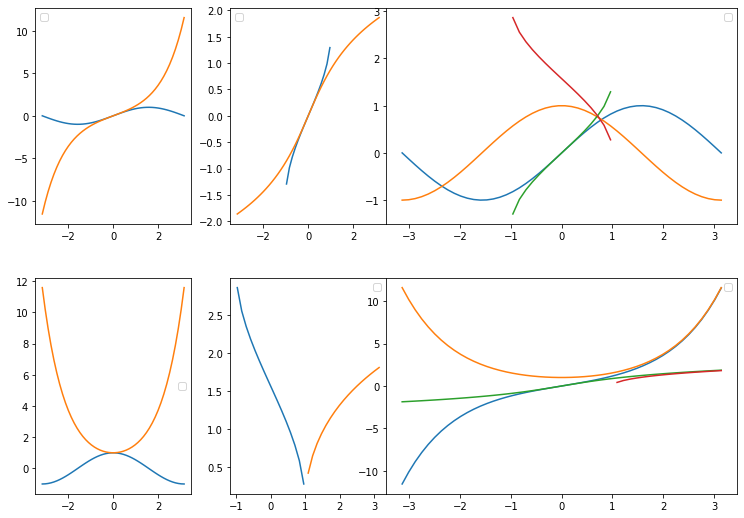

In [124]:
fig1 = fg1.calculateFigsize(); fig2 = fg2.calculateFigsize()
figsize = [fig1[0] + fig2[0], max(fig1[1], fig2[1])]
fig = plt.figure(figsize = figsize)
subfigs = fig.subfigures(1, 2, wspace = 0)
fg1.plot(subfigs[0])
fg2.plot(subfigs[1])
# plt.savefig('isthisworking.png')

In [117]:
arr = np.random.random((2,2))
print(arr)
np.sum(arr, axis = 0)

[[0.4987718  0.25759275]
 [0.15003503 0.95661408]]


array([0.64880683, 1.21420683])

In [51]:
# fg.tickArgs('both', 'both', labelsize = 14, slc = (-1, -1))
# fg.tickArgs('x', 'major', labelsize = 16)
# fg.spineArgs('left', color = 'blue', slc = (1,1))
# fg.spineArgs('right', color = 'red')
# fg.axisArgs(ylim = (-0.5, 0.5))
# fg.axisArgs(xscale = 'log', slc = (0,0))


In [13]:
plt.show()

In [53]:
fg.fig.get_size_inches()

array([7.74, 7.74])

In [120]:
arr = np.ones(2)

In [121]:
arr

array([1., 1.])

In [122]:
arr = np.reshape(arr, (1, -1))

In [123]:
arr.shape

(1, 2)

In [ ]:
    def makeFig(self, nrows, ncols, panel_length = 3, 
            wspace = 0.25, hspace = 0.25, 
            xborder = [0.33, 0], yborder = [0, 0.33], 
            height_ratios = None, 
            width_ratios = None, 
            fig_kwargs = {}):
        """
        Make a figure according to the
        given specifications for the subpanels.

        Args:
            nrows (int): number of rows
            ncols (int): number of columns
            panel_length (float): size of panel in inches.
                Used to scale the other inputs.
            wspace (float, np.array): the width of the padding
                between panels, as a fraction of panel_length.
                If a float, applies that value to all padding.
                An array must have dimensions (ncols - 1).
            hspace (float, np.array): the height of the padding
                between panels, as a fraction of panel_length.
                If a float, applies that value to all padding.
                An array must have dimensions (nrows - 1).
            xborder (float, np.array): the size of the padding
                on the left and right borders of the figure.
                As a fraction of panel_length. If given a float,
                applies that value to both borders.
            yborder (float, np.array): the size of the padding
                on the top and bottom borders of the figure.
                As a fraction of panel_length. If given a float,
                applies that value to both borders.
            height_ratios (list, np.array, optional): the 
                respective heights of each the panels in the 
                corresponding rows. Must have dimensions (nrows). 
                As a fraction of panel_length. 
            width_ratios (list, np.array, optional): the respective heights
                of each the panels in the corresponding rows. Must
                have dimensions (nrows). As a fraction of 
                panel_length. 
            fig_kwargs #TODO

        """

        # default behavior for borders
        if isinstance(xborder, float) or isinstance(xborder, int):
            xborder = np.array([xborder, xborder])
        if isinstance(yborder, float) or isinstance(yborder, int):
            yborder = np.array([yborder, yborder])
        if isinstance(xborder, list):
            xborder = np.array(xborder)
        if isinstance(yborder, list):
            yborder = np.array(yborder)

        if isinstance(wspace, list):
            wspace = np.array(wspace)
        if isinstance(hspace, list):
            hspace = np.array(hspace)
        # default behavior for padding
        paddim = [max(1, ncols - 1), max(1, nrows - 1)]
        if isinstance(wspace, float) or isinstance(wspace, int):
            if ncols == 1:
                wspace = np.zeros(0)
            else:
                wspace = np.ones(paddim[0]) * wspace
        if isinstance(hspace, float) or isinstance(hspace, int):
            if nrows == 1:
                hspace = np.zeros(0)
            else:
                hspace = np.ones(paddim[1]) * hspace

        # default behavior for ratios
        if height_ratios is None:
            height_ratios = np.ones(nrows)
        else:
            # renormalize
            maxval = np.max(height_ratios)
            height_ratios /= maxval

        if width_ratios is None:
            width_ratios = np.ones(ncols)
        else:
            #renormalize
            maxval = np.max(width_ratios)
            width_ratios /= maxval

        #TODO handle input errors with panelbt, height/width ratios

        # creating Figure object

        # convert everything into units of inches
        width_ratios *= panel_length; height_ratios *= panel_length
        xborder *= panel_length; yborder *= panel_length
        wspace *= panel_length; hspace *= panel_length
        
        total_widths = np.sum(width_ratios)
        total_wspace = np.sum(wspace)
        wborder_space = np.sum(xborder)

        total_heights = np.sum(height_ratios)
        total_hspace = np.sum(hspace)
        hborder_space = np.sum(yborder)
        
        # get figwidth and figheight in inches
        figwidth = total_widths + total_wspace + wborder_space
        figheight = total_heights + total_hspace + hborder_space 

        fig_kwargs['figsize'] = (figwidth, figheight)
        fig = plt.figure(**fig_kwargs)
        
        self.fig = fig
        self.xborder = xborder
        self.yborder = yborder
        self.wspace = wspace 
        self.hspace = hspace
        self.figsize = [figwidth, figheight]
        self.panel_length = panel_length
        self.panel_heights = height_ratios
        self.panel_widths = width_ratios
        self.dim = [nrows, ncols]

        self.makeAxes()
        return fig